## Import libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string 
from google.colab import files
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

## Load data

In [25]:
!git clone https://github.com/quanho114/amazon-feedback-ai-agent.git

Cloning into 'amazon-feedback-ai-agent'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 87 (delta 0), reused 9 (delta 0), pack-reused 71 (from 1)
Receiving objects: 100% (87/87), 37.65 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [26]:
%cd amazon-feedback-ai-agent

/content/amazon-feedback-ai-agent/amazon-feedback-ai-agent


In [27]:
df = pd.read_csv("data/processed/reviews_clean.csv")
df.head()

,Review Count,Review Date,Rating,Review Title,Review Text,clean_review,review_length,num_exclamations,num_questions,has_uppercase,day_of_week
0,1 review,2024-09-16 13:44:26+00:00,1,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","i registered on the website, tried to order a ...",106,0,0,False,Monday
1,9 reviews,2024-09-16 18:26:46+00:00,1,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,had multiple orders one turned up and driver h...,53,0,0,False,Monday
2,90 reviews,2024-09-16 21:47:39+00:00,1,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,i informed these reprobates that i would not b...,122,3,0,False,Monday
3,5 reviews,2024-09-17 07:15:49+00:00,1,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,i have bought from amazon before and no proble...,82,0,0,False,Tuesday
4,8 reviews,2024-09-16 18:37:17+00:00,1,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,if i could give a lower rate i would! i cancel...,100,5,0,False,Monday


In [28]:
# Select columns 
columns = ['Rating', 'clean_review', 'day_of_week']
df = df[columns].copy()
df.head()

,Rating,clean_review,day_of_week
0,1,"i registered on the website, tried to order a ...",Monday
1,1,had multiple orders one turned up and driver h...,Monday
2,1,i informed these reprobates that i would not b...,Monday
3,1,i have bought from amazon before and no proble...,Tuesday
4,1,if i could give a lower rate i would! i cancel...,Monday


## Map Rating to Sentiment

In [29]:
def map_sentiment(r):
    if r <= 2:
        return 'negative'
    elif r == 3:
        return 'neutral'
    else:
        return 'positive'
    
df['sentiment'] = df['Rating'].apply(map_sentiment)
df.head()

,Rating,clean_review,day_of_week,sentiment
0,1,"i registered on the website, tried to order a ...",Monday,negative
1,1,had multiple orders one turned up and driver h...,Monday,negative
2,1,i informed these reprobates that i would not b...,Monday,negative
3,1,i have bought from amazon before and no proble...,Tuesday,negative
4,1,if i could give a lower rate i would! i cancel...,Monday,negative


## EDA

/tmp/ipython-input-1091304729.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=['negative','neutral','positive'],


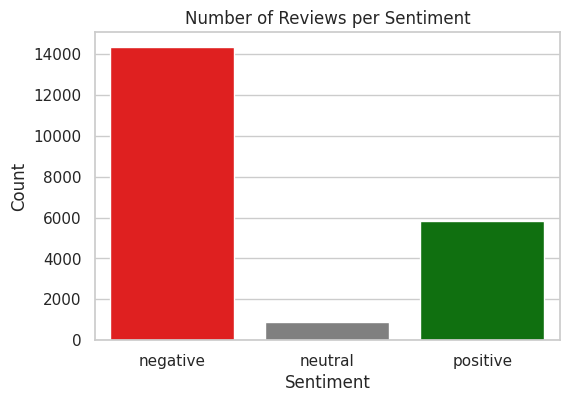

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['negative','neutral','positive'],
              palette=['red','gray','green'])
plt.title("Number of Reviews per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [31]:
print("Sample negative review:\n")
print(df[df['sentiment']=='negative'].sample(1)['clean_review'].iloc[0])

print("\nSample positive review:\n")
print(df[df['sentiment']=='positive'].sample(1)['clean_review'].iloc[0])

Sample negative review:

amazon is dishonest as the days are long!!!!i returned items and instead of them refunding my credit card they take it their own to give you store credit without your permission to do so.i called and called customer service and all i get was a run around. i am going to keep after them until i get moneybeware do not order from this company they are dishonest and crooks.they deserve zero star than the one i marked

Sample positive review:

one of my favourite companies of all time. i use amazon a ton. i get almost all my books from amazon, and a whole lot of other stuff too. for such big company, their customer service is amazing.


In [32]:
df['review_len'] = df['clean_review'].apply(lambda x: len(str(x).split()))

review_len_clipped = df['review_len'].clip(upper=300)

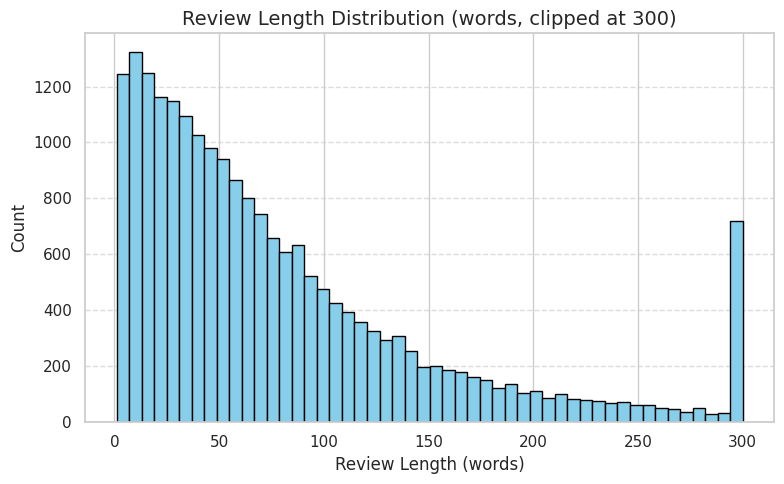

In [33]:
# Clip review length at 300 words
review_len_clipped = df['review_len'].clip(upper=300)

# Create histogram using matplotlib
plt.figure(figsize=(8, 5))
plt.hist(
    review_len_clipped,
    bins=50,
    color='skyblue',           # fill color
    edgecolor='black',         # border color
    linewidth=1
)

# Add titles and labels
plt.title("Review Length Distribution (words, clipped at 300)", fontsize=14)
plt.xlabel("Review Length (words)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

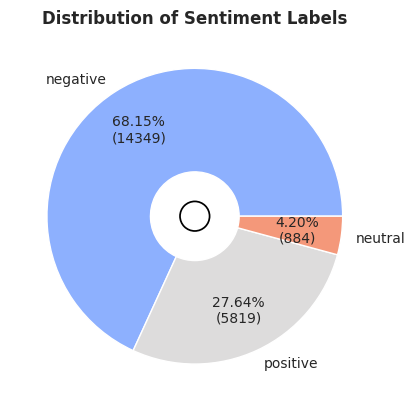

In [34]:
sentiment_counts = df['sentiment'].value_counts()
colors = sns.color_palette("coolwarm", len(sentiment_counts))  # Dải màu coolwarm từ seaborn
fig, ax = plt.subplots()
ax.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct=lambda p: f'{p:.2f}%\n({int(p * sentiment_counts.sum() / 100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10),
    pctdistance=0.7,
    colors=colors  
)
center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)
plt.title("Distribution of Sentiment Labels", weight="bold")
plt.show()

<Figure size 1000x1000 with 0 Axes>

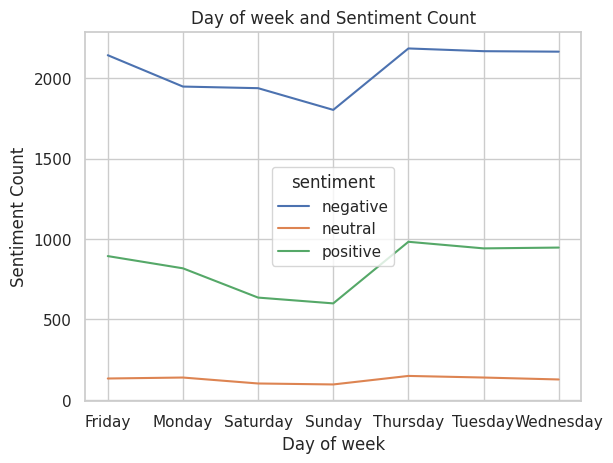

In [35]:
plt.figure(figsize=(10, 10))
df.groupby(['day_of_week', 'sentiment']).size().unstack().plot(legend=True)
plt.title('Day of week and Sentiment Count')
plt.xlabel('Day of week')
plt.ylabel('Sentiment Count')
plt.show()

In [36]:
df['polarity'] = df['clean_review'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['clean_review'].astype(str).apply(len)
df['word_count'] = df['clean_review'].apply(lambda x: len(str(x).split()))

In [37]:
df.head()

,Rating,clean_review,day_of_week,sentiment,review_len,polarity,word_count
0,1,"i registered on the website, tried to order a ...",Monday,negative,587,-0.125000,106
1,1,had multiple orders one turned up and driver h...,Monday,negative,293,-0.333333,53
2,1,i informed these reprobates that i would not b...,Monday,negative,608,-0.227381,122
3,1,i have bought from amazon before and no proble...,Tuesday,negative,450,-0.140000,82
4,1,if i could give a lower rate i would! i cancel...,Monday,negative,538,0.000000,100


sentiment polarity distribution

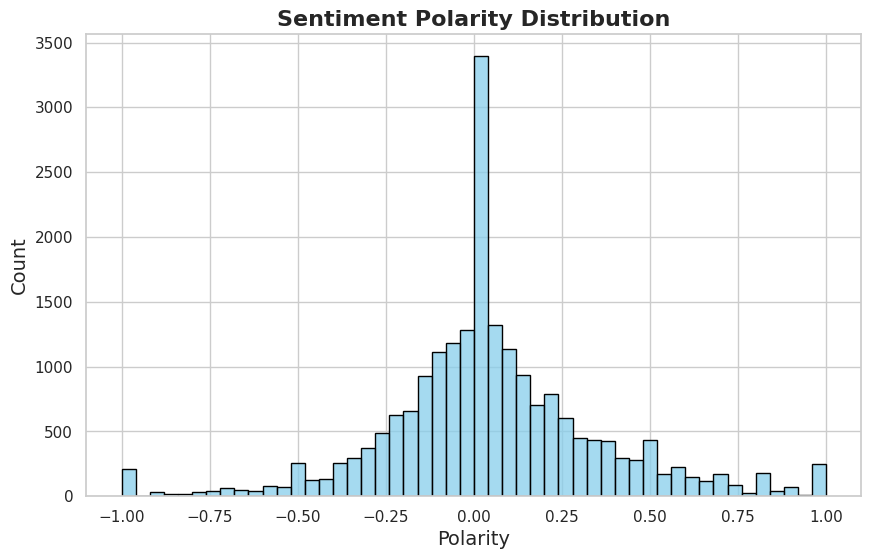

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity'], bins=50, kde=False, color='skyblue', edgecolor='black')
plt.title('Sentiment Polarity Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Polarity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Review rating 

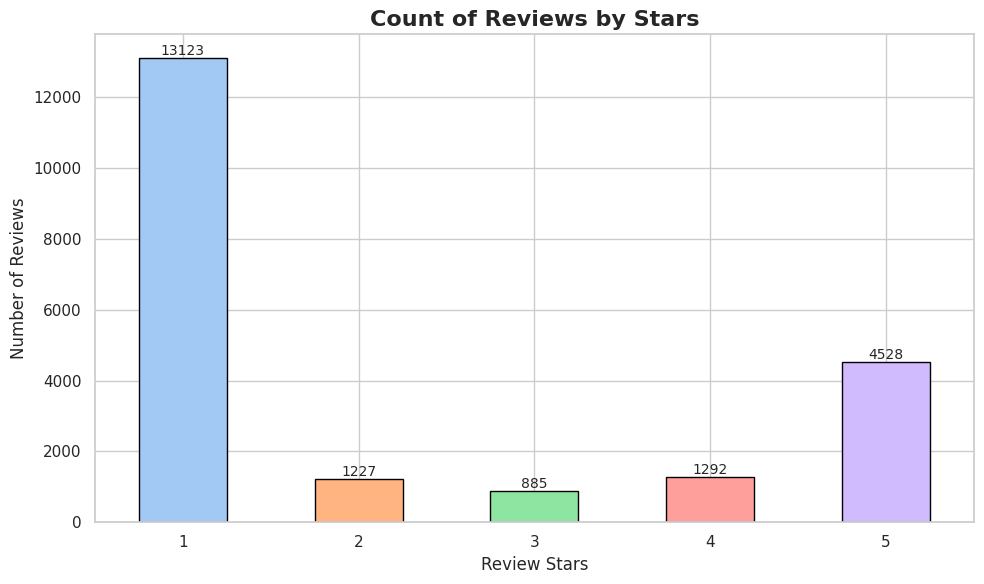

In [39]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
barplot = df['Rating'].value_counts().sort_index().plot(
    kind='bar',
    color=sns.color_palette("pastel"),
    edgecolor='black',
    ax=ax
)
ax.set_title('Count of Reviews by Stars', fontsize=16, fontweight='bold')
ax.set_xlabel('Review Stars', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

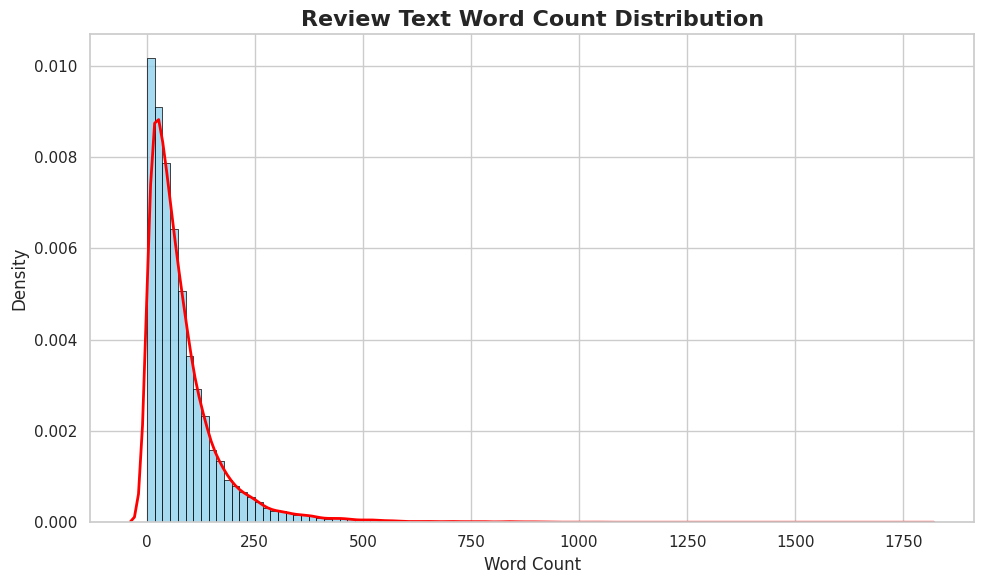

In [40]:
word_counts = df['word_count'].dropna()
word_counts = word_counts[word_counts > 0] 

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(word_counts, 
             bins=100, 
             color='skyblue', 
             edgecolor='black', 
             stat='density') 

# KDE line
sns.kdeplot(word_counts, 
            color='red', 
            linewidth=2)

# Nhãn và tiêu đề
plt.title('Review Text Word Count Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

word cloud for negative

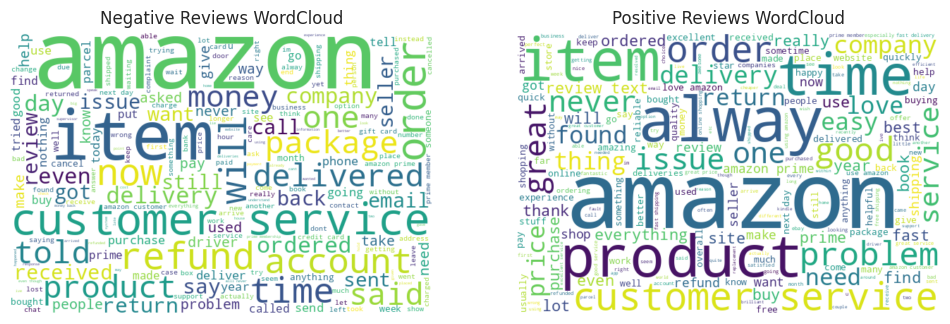

Top 10 negative words: [('the', 52653), ('to', 49939), ('i', 48141), ('and', 40706), ('a', 32332), ('they', 23041), ('my', 20770), ('amazon', 20441), ('of', 17714), ('for', 17413)]
Top 10 positive words: [('i', 7608), ('and', 7019), ('the', 7001), ('to', 5265), ('a', 4928), ('amazon', 3610), ('is', 2982), ('of', 2831), ('have', 2763), ('for', 2651)]


In [41]:
# Combine cleaned text per class
neg_text = " ".join(df[df['sentiment']=='negative']['clean_review'])
pos_text = " ".join(df[df['sentiment']=='positive']['clean_review'])

# Wordclouds
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
wordcloud_neg = WordCloud(width=600, height=400, background_color='white').generate(neg_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")

plt.subplot(1,2,2)
wordcloud_pos = WordCloud(width=600, height=400, background_color='white').generate(pos_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")
plt.show()

# Most common words
neg_counter = Counter(neg_text.split())
pos_counter = Counter(pos_text.split())
print("Top 10 negative words:", neg_counter.most_common(10))
print("Top 10 positive words:", pos_counter.most_common(10))

/tmp/ipython-input-3444857474.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3444857474.py:15: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipython-input-3444857474.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3444857474.py:26: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


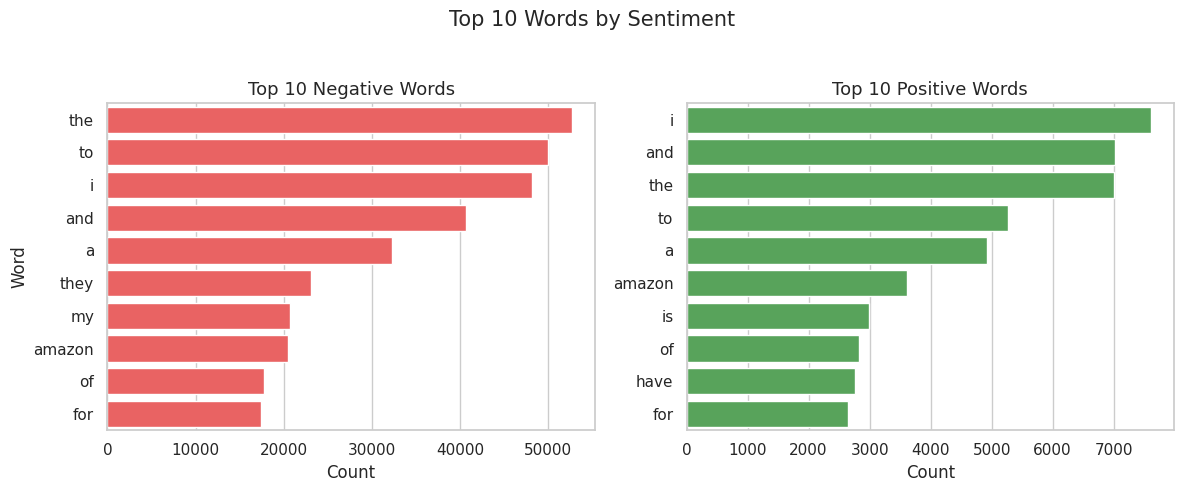

In [42]:
# Count top 10 words for each sentiment
neg_counter = Counter(neg_text.split())
pos_counter = Counter(pos_text.split())

neg_top10 = pd.DataFrame(neg_counter.most_common(10), columns=['word', 'count'])
pos_top10 = pd.DataFrame(pos_counter.most_common(10), columns=['word', 'count'])

# Set style
sns.set(style="whitegrid")

# Create subplot: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Negative Words ---
sns.barplot(
    x='count', y='word',
    data=neg_top10,
    palette=['#ff4d4d'],
    ax=axes[0]
)
axes[0].set_title("Top 10 Negative Words", fontsize=13)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Word")

# --- Positive Words ---
sns.barplot(
    x='count', y='word',
    data=pos_top10,
    palette=['#4CAF50'],
    ax=axes[1]
)
axes[1].set_title("Top 10 Positive Words", fontsize=13)
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

# Adjust layout
plt.suptitle("Top 10 Words by Sentiment", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Feature Engineering 

split train/val/test

In [43]:
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42, stratify=y_train
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


Train: 14738
Val: 2106
Test: 4211


TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

ifidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = ifidf.fit_transform(X_train)
X_val_tfidf = ifidf.transform(X_val)
X_test_tfidf = ifidf.transform(X_test)

print("TF-IDF shape:")
print("Train:", X_train_tfidf.shape)
print("Val:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

TF-IDF shape:
Train: (14738, 5000)
Val: (2106, 5000)
Test: (4211, 5000)


Logistic

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


### Logistic Regression Validation Accuracy: **0.8927**

,precision,recall,f1-score,support
Negative,0.909389,0.965157,0.936444,1435.000000
Neutral,0.000000,0.000000,0.000000,89.000000
Positive,0.851979,0.850515,0.851247,582.000000
accuracy,0.892688,0.892688,0.892688,0.892688
macro avg,0.587123,0.605224,0.595897,2106.000000
weighted avg,0.855093,0.892688,0.873325,2106.000000


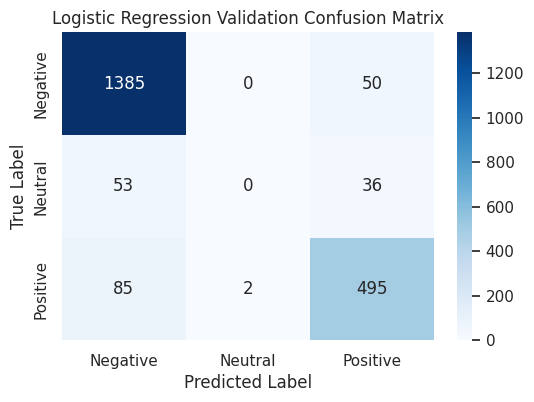

In [45]:
from IPython.display import display, Markdown
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1, random_state=42)

# Fit
log_reg.fit(X_train_tfidf, y_train)

# Validation
y_val_pred = log_reg.predict(X_val_tfidf)

def evaluate_model(step ,y_true, y_pred, labels=None, show_cm=True):
    acc = accuracy_score(y_true, y_pred)
    display(Markdown(f"### {step} Accuracy: **{acc:.4f}**"))

    report_dict = classification_report(
        y_true, y_pred,
        output_dict=True,
        target_names=labels
    )
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    if show_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{step} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    
    return report_df, acc

df_report_val_lr, acc_val_lr = evaluate_model("Logistic Regression Validation", y_val, y_val_pred, labels=["Negative", "Neutral", "Positive"])

### Logistic Regression Test Accuracy: **0.8948**

,precision,recall,f1-score,support
Negative,0.912368,0.961324,0.936206,2870.000000
Neutral,0.000000,0.000000,0.000000,177.000000
Positive,0.851477,0.866838,0.859089,1164.000000
accuracy,0.894799,0.894799,0.894799,0.894799
macro avg,0.587948,0.609388,0.598432,4211.000000
weighted avg,0.857187,0.894799,0.875538,4211.000000


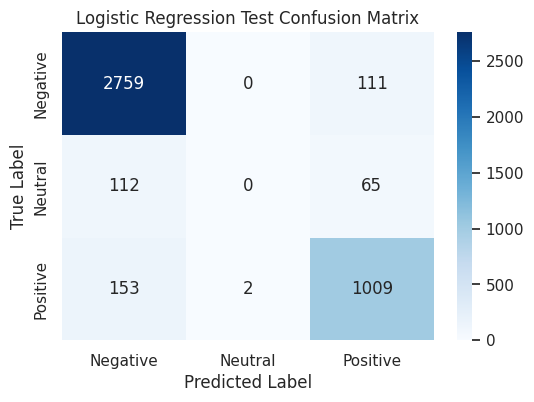

In [46]:
# Prediction on test set
y_test_pred = log_reg.predict(X_test_tfidf)
df_report_test_lr, acc_test_lr = evaluate_model("Logistic Regression Test", y_test, y_test_pred, labels=["Negative","Neutral", "Positive"])

# Finetune RoBERTa

In [48]:
from transformers import RobertaTokenizerFast

tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [50]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_length = np.max(token_lens)
max_length

np.int64(512)

In [54]:
MAX_LEN = 128

In [60]:
def tokenize_roberta(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for txt in data:
        encoded = tokenizer_roberta.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',     
            truncation=True,           
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = np.array(input_ids, dtype=np.int32)
    attention_masks = np.array(attention_masks, dtype=np.int32)
    
    return input_ids, attention_masks


In [61]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train.tolist(), MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_val.tolist(), MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test.tolist(), MAX_LEN)

In [65]:
import tensorflow as tf
from transformers import TFRobertaModel

def create_model(bert_model, max_len=MAX_LEN, num_classes=3):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    
    bert_outputs = bert_model([input_ids, attention_masks])
    pooled_output = bert_outputs.pooler_output  
    
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(pooled_output)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])
    
    return model


In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [68]:
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [72]:
model = create_model(roberta_model, max_len=MAX_LEN, num_classes=3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model_2 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 rtaModel)                   ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

In [73]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_enc,
    validation_data=([val_input_ids, val_attention_masks], y_val_enc),
    epochs=4,
    batch_size=32
)

Epoch 1/4
461/461 [==============================] - 424s 811ms/step - loss: 0.2957 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.2392 - val_sparse_categorical_accuracy: 0.9274
Epoch 2/4
461/461 [==============================] - 371s 805ms/step - loss: 0.2015 - sparse_categorical_accuracy: 0.9336 - val_loss: 0.2054 - val_sparse_categorical_accuracy: 0.9292
Epoch 3/4
461/461 [==============================] - 371s 804ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.2230 - val_sparse_categorical_accuracy: 0.9321
Epoch 4/4
461/461 [==============================] - 371s 804ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.2119 - val_sparse_categorical_accuracy: 0.9283


In [76]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

132/132 [==============================] - 37s 257ms/step


In [77]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [79]:
def conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

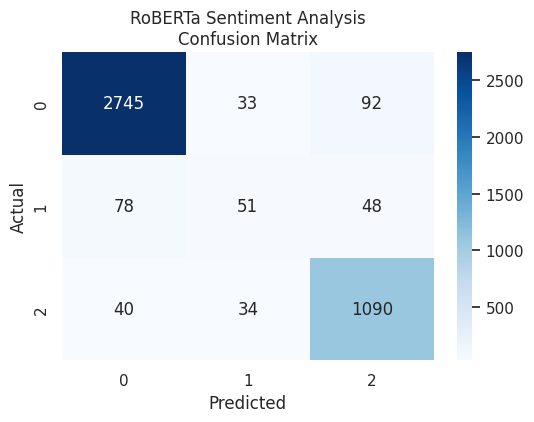

In [81]:
conf_matrix(
    y_test_enc,
    y_pred_roberta.argmax(1),
    "RoBERTa Sentiment Analysis\nConfusion Matrix"
)


In [83]:
print('\nClassification Report for RoBERTa:\n')
print(classification_report(
    y_test_enc,
    y_pred_roberta.argmax(axis=1),
    target_names=['Negative', 'Neutral', 'Positive']
))



Classification Report for RoBERTa:

              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96      2870
     Neutral       0.43      0.29      0.35       177
    Positive       0.89      0.94      0.91      1164

    accuracy                           0.92      4211
   macro avg       0.76      0.73      0.74      4211
weighted avg       0.92      0.92      0.92      4211



Save model

In [87]:
import joblib
import os
os.makedirs("models", exist_ok=True)

In [88]:
model.save("models/roberta_model")
print("Model saved in models/roberta_model!")

Model saved in models/roberta_model!


In [102]:
import numpy as np

def predict_sentiment(texts, model, tokenizer, label_encoder, max_len=128):
    """
    texts: list of strings
    model: Keras fine-tuned Roberta model
    tokenizer: RobertaTokenizerFast
    label_encoder: LabelEncoder dùng để encode y
    max_len: chiều dài sequence
    """
    # Tokenize
    input_ids, attention_masks = [], []
    for txt in texts:
        encoded = tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = np.array(input_ids, dtype=np.int32)
    attention_masks = np.array(attention_masks, dtype=np.int32)
    
    # Dự đoán
    probs = model.predict([input_ids, attention_masks])
    preds = np.argmax(probs, axis=1)
    
    # Decode nhãn
    return label_encoder.inverse_transform(preds)


In [104]:
complex_texts = [
    "I thought this would be great, but honestly it's a total disappointment.",
    "The product is okay, but the packaging ruined the whole experience.",
    "Absolutely fantastic! Couldn't be happier with the purchase.",
    "I don't hate it, but I also don't love it.",
    "Customer support was friendly, but the delivery took forever."
]

pred_labels = predict_sentiment(complex_texts, model, tokenizer_roberta, le)

for text, label in zip(complex_texts, pred_labels):
    print(f"Text: {text}")
    print(f"Predicted sentiment: {label}")
    print("---")


1/1 [==============================] - 0s 97ms/step
Text: I thought this would be great, but honestly it's a total disappointment.
Predicted sentiment: negative
---
Text: The product is okay, but the packaging ruined the whole experience.
Predicted sentiment: neutral
---
Text: Absolutely fantastic! Couldn't be happier with the purchase.
Predicted sentiment: positive
---
Text: I don't hate it, but I also don't love it.
Predicted sentiment: neutral
---
Text: Customer support was friendly, but the delivery took forever.
Predicted sentiment: neutral
---
